In [1]:
import emd
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os, sys

In [5]:
import pickle

path_ = os.getcwd()
#print(path_)
path_ = os.chdir('C:\\Users\\mehrd\\Documents\\datasets')


with open('data_list_bl_h.pkl','rb') as f:
    data_list_bl_h = pickle.load(f)
f.close()

with open('data_list_bl_m.pkl','rb') as f:
    data_list_bl_m = pickle.load(f)
f.close()

with open('data_list_q_h.pkl','rb') as f:
    data_list_q_h = pickle.load(f)
f.close()

with open('data_list_q_m.pkl','rb') as f:
    data_list_q_m = pickle.load(f)
f.close()




In [ ]:
'''
This is the real shit they used for the analysis
'''

import emd
import numpy as np
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define and simulate a simple signal
peak_freq = 12
sample_rate = 512
seconds = 10
noise_std = .5
x = emd.utils.ar_simulate(peak_freq, sample_rate, seconds, noise_std=noise_std, random_seed=42, r=.99)[:, 0]
x = x*1e-4
t = np.linspace(0, seconds, seconds*sample_rate)

# sphinx_gallery_thumbnail_number = 6


# Plot the first 5 seconds of data
plt.figure(figsize=(10, 2))
plt.plot(t[:sample_rate*3], x[:sample_rate*3], 'k')

#The Hilbert-Huang Transform

The Hilbert-Huang transform provides a description of how the energy or power within a signal is distributed across frequency. The distributions are based on the instantaneous frequency and amplitude of a signal.

To get started, lets simulate a noisy signal with a 12Hz oscillation.

In [8]:
x = data_list_bl_m[0]

We then extract the IMFs using a mask sift with the default options

In [13]:
imf = emd.sift.mask_sift(x, max_imfs=6)
emd.plotting.plot_imfs(imf[:2000, :], cmap=True, scale_y=True)

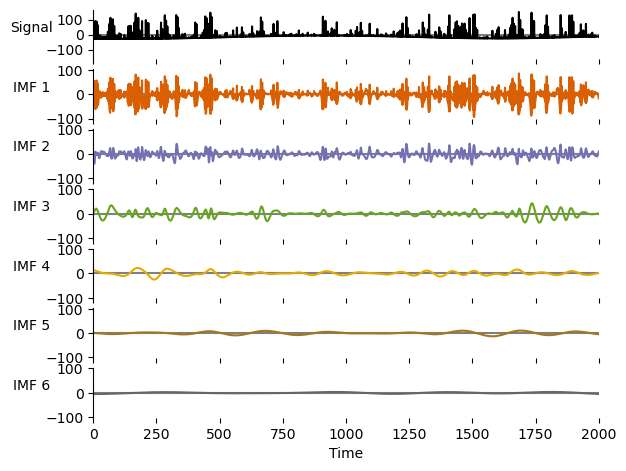

In [14]:
plt.show()

#1d frequency transform

Next we use emd.spectra.frequency_transform to compute the frequency content of the IMFs. This function returns the instantaneous phase, frequency and amplitude of each IMF. It takes a set of intrinsic mode functions, the sample rate and a mode as input arguments. The mode determines the algorithm which is used to compute the frequency transform, several are available but in this case we use nht which specifies the Normalised-Hilbert Transform. This is a good general purpose choice which should work well in most circumstances.

In [17]:
# Compute frequency statistics
sample_rate = 60
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

The Hilbert-Huang transform can be thought of as an amplitude-weighted histogram of the instantaneous-frequency values from an IMF. The next sections break this down into parts.

To get started, we can plot a simple histogram of IF values using matplotlibs built-in hist function. We do this twice, once as a standard count and once by weighting the observations by their amplitude.

We will concentrate on IMF-3 from now as it contains our 12Hz oscillation.

In [18]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
# Plot a simple histogram using frequency bins from 0-20Hz
plt.hist(IF[:, 2], np.linspace(0, 20))
plt.grid(True)
plt.title('IF Histogram')
plt.xticks(np.arange(0, 20, 2))
plt.xlabel('Frequency (Hz)')

plt.subplot(122)
# Plot an amplitude-weighted histogram using frequency bins from 0-20Hz
plt.hist(IF[:, 2], np.linspace(0, 20), weights=IA[:, 2])
plt.grid(True)
plt.title('IF Histogram\nweighted by IA')
plt.xticks(np.arange(0, 20, 2))
plt.xlabel('Frequency (Hz)')

Text(0.5, 0, 'Frequency (Hz)')

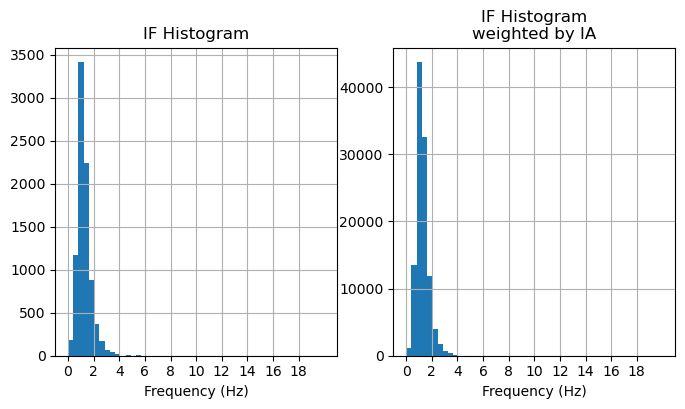

In [19]:
plt.show()

In this case our two distributions are pretty similar. Both are centred around 12Hz (as we would expect) and both have tails stretching between about 6-18Hz. These tails are smaller in the amplitude-weighted histogram on the right, suggesting that these outlying frequency values tend to occur at time points with very low amplitude.

The EMD toolbox provides a few functions to compute a few variants of the Hilbert-Huang transform. The first step is to define the frequency bins to use in the histogram with emd.spectra.define_hist_bins. This takes a minimum frequency, maximum frequency and number of frequency steps as the main arguments and returns arrays containing the edges and centres of the defined bins.

Lets take a look at a couple of examples, first we define 4 bins between 1 and 5Hz

In [20]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 5, 4)
print('Bin Edges:   {0}'.format(freq_edges))
print('Bin Centres: {0}'.format(freq_centres))

Bin Edges:   [1. 2. 3. 4. 5.]
Bin Centres: [1.5 2.5 3.5 4.5]


This returns 5 bin edges and 4 bin centres which we can use to create and plot our Hilbert-Huang transform. This choice of frequency bin size defines the resolution of transform and is free to be tuned to the application at hand.

Several other options are available. For instance, we can specify a log bin spacing between 1 and 50Hz (the default option is a uniform linear spacing).

In [21]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 50, 8, 'log')

# We round the values to 3dp for easier visualisation
print('Bin Edges:   {0}'.format(np.round(freq_edges, 3)))
print('Bin Centres: {0}'.format(np.round(freq_centres, 3)))

Bin Edges:   [ 1.     1.631  2.659  4.336  7.071 11.531 18.803 30.662 50.   ]
Bin Centres: [ 1.315  2.145  3.498  5.704  9.301 15.167 24.732 40.331]


Once we have our frequency bins defined, we can compute the Hilbert-Huang transform. The simplest HHT is computed by emd.spectra.hilberthuang_1d. This returns a vector containing the weighted histograms for each IMF within the bins specified by edges

Here, we defined a set of linear bins between 0 and 100Hz and compute both a weighted and unweighed HHT.

In [93]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 100, 128, 'linear')

# Amplitude weighted HHT
spec_weighted = emd.spectra.hilberthuang_1d(IF, IA, freq_edges)

# Unweighted HHT - we replace the instantaneous amplitude values with ones
spec_unweighted = emd.spectra.hilberthuang_1d(IF, np.ones_like(IA), freq_edges)

We can visualise these distributions by plotting the HHT across frequencies. Note that though we use the freq_edges to define the histogram, we visualise it by plotting the value for each bin at its centre frequency.

In [99]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(freq_centres, spec_unweighted)
plt.xticks(np.arange(8)*12)
plt.xlim(0, 100)
plt.ylim(0, 2500)
plt.xlabel('Frequency (Hz)')
plt.title('unweighted\nHilbert-Huang Transform')

plt.subplot(122)
plt.plot(freq_centres, spec_weighted)
plt.xticks(np.arange(8)*12)
plt.xlim(0, 100)
plt.ylim(0, 2500)
plt.xlabel('Frequency (Hz)')
plt.title('IA-weighted\nHilbert-Huang Transform')
plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5'])

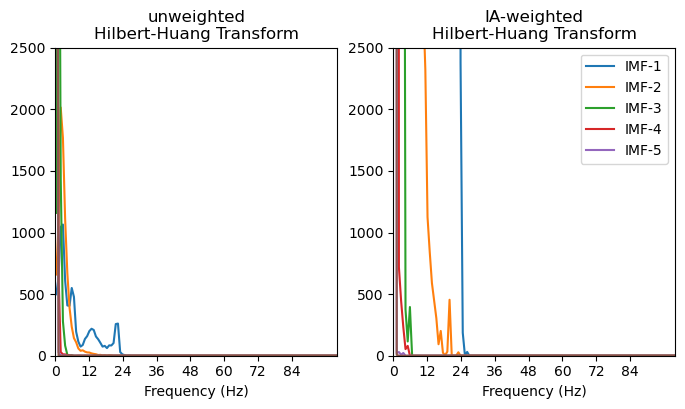

In [100]:
plt.show()

The frequency content of all IMFs are visible in the unweighted HHT. We can see that each IMF contains successively slower dynamics and that the high frequency IMFs tend to have wider frequency distributions.

All but IMF-3 are greatly reduced in the weighted HHT. This tells us that the frequency content in the other IMFs occurred at relatively low power - as we would expect from our simulated 12Hz signal.

#2d time-frequency transform

The Hilbert-Huang transform can also be computed across time to explore any dynamics in instantaneous frequency. This is conceptually very similar to the 1d HHT, we compute a weighted histogram of instantaneous frequency values except now we compute a separate histogram for each time-point.

As before, we start by defining the frequency bins. The time bins are taken at the sample rate of the data. The 2d frequency transform is computed by emd.spectra.hilberthuang

In [54]:
# Carrier frequency histogram definition
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 25, 24, 'linear')

hht = emd.spectra.hilberthuang(IF[:, 2, None], IA[:, 2, None], freq_edges, mode='amplitude')
time_centres = np.arange(201)-.5

We can visualise what the Hilbert-Huang transform is doing in 2d by plotting the HHT and IF on the same plot. Here we zoom into a short segment of the simulation and plot the IMF-3 time course and instantaneous amplitude values in the top panel.

The bottom panel shows a grid cast across a set of time-frequency axes. The time steps are defined by the sample rate of the data and the frequency steps are defined by our histogram bins above. We plot both the HHT and the IF on these axes.

In [61]:
plt.figure(figsize=(10, 8))
# Add signal and IA
plt.axes([.1, .6, .64, .3])
plt.plot(imf[:, 2], 'k')
plt.plot(IA[:, 2], 'r')
plt.legend(['IMF', 'IF'])
plt.xlim(50, 150)

# Add IF axis and legend
plt.axes([.1, .1, .8, .45])
plt.plot(IF[:, 2], 'g', linewidth=3)
plt.legend(['IF'])

# Plot HHT
plt.pcolormesh(time_centres, freq_edges, hht[:, :200], cmap='hot_r', vmin=0)

# Set colourbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

# Add some grid lines
for ii in range(len(freq_edges)):
    plt.plot((0, 200), (freq_edges[ii], freq_edges[ii]), 'k', linewidth=.5)
for ii in range(200):
    plt.plot((ii, ii), (0, 20), 'k', linewidth=.5)

# Overlay the IF again for better visualisation
plt.plot(IF[:, 2], 'g', linewidth=3)

# Set lims and labels
plt.xlim(50, 150)
plt.ylim(0, 5)
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

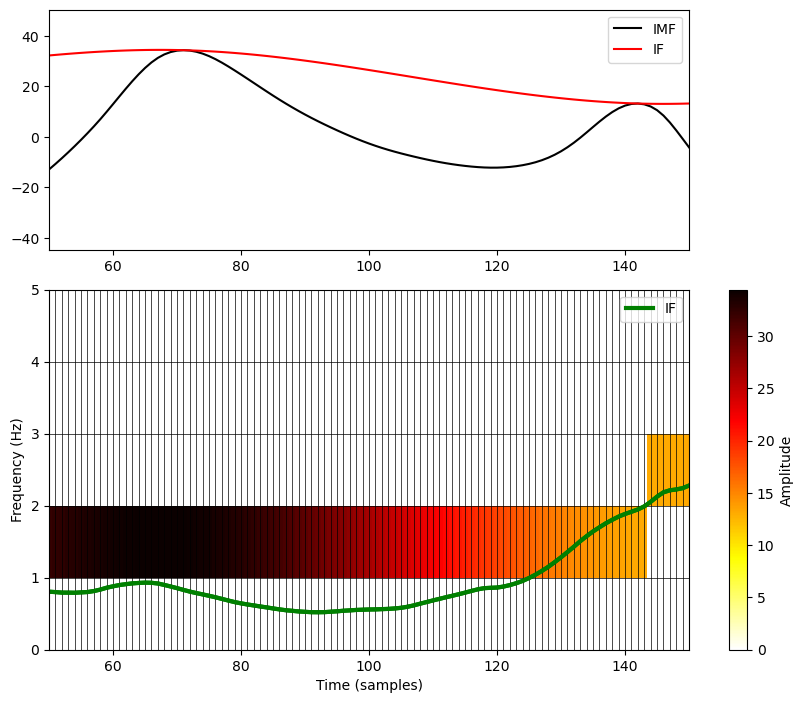

In [62]:
plt.show()

The green line in the bottom panel is the instantaneous frequency of IMF-3. At each point in time, we determine which frequency bin the instantaneous frequency is within and place the corresponding instantaneous amplitude into that cell of the HHT.

This is effectively quatising (or digitising) the instantaneous frequency values within our defined frequnecy bins. We can only see frequency dynamics in the HHT when the IF crosses between the edges of the frequency bins. Though this reduces our frequency resolution a little, it means that we can easly visualise the amplitude and frequency information together in the same plot.

If we want a higher frequency resolution, we can simply increase the number of frequency bins when defining the histogram parameters in emd.spectra.define_hist_bins. Here, we repeat our plot using three times more bins.

This greatly increases the frequency-resolution in the y-axis. This can be tuned to meet your needs depending on the analysis in-hand and computational demands. A Hilbert-Huang Transform of a long time-series with very high frequency resolution can create a very large matrix….

Similarly, we could specify a log-frequency scale by changing the definition in emd.spectra.define_hist_bins

In [64]:
# Carrier frequency histogram definition
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 25, 24*3, 'linear')

hht = emd.spectra.hilberthuang(IF[:, 2], IA[:, 2], freq_edges, mode='amplitude')
time_centres = np.arange(201)-.5

# Create summary figure

plt.figure(figsize=(10, 6))
plt.plot(IF[:, 2], 'g', linewidth=3)
plt.legend(['IF'])

# Plot HHT
plt.pcolormesh(time_centres, freq_edges, hht[:, :200], cmap='hot_r', vmin=0)

# Set colourbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

# Add some grid lines
for ii in range(len(freq_edges)):
    plt.plot((0, 200), (freq_edges[ii], freq_edges[ii]), 'k', linewidth=.5)
for ii in range(200):
    plt.plot((ii, ii), (0, 20), 'k', linewidth=.5)

# Overlay the IF again for better visualisation
plt.plot(IF[:, 2], 'g', linewidth=3)

# Set lims and labels
plt.xlim(50, 150)
plt.ylim(1, 5)
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

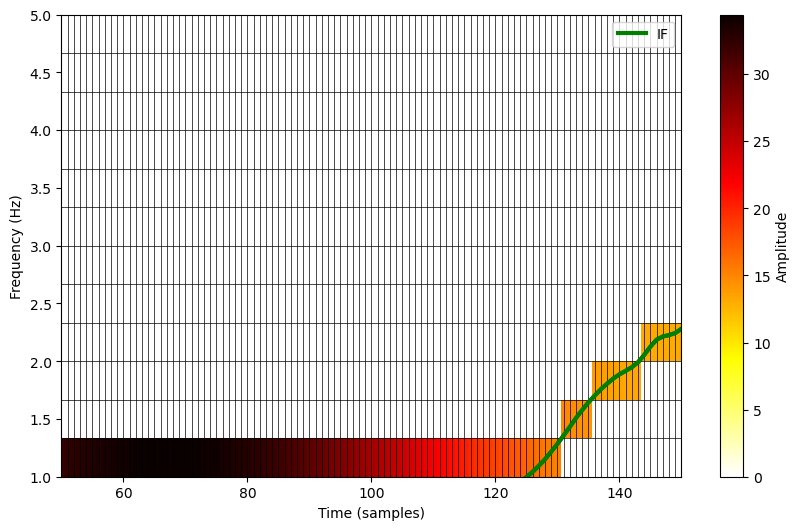

In [65]:
plt.show()

Let us zoom back out to a longer section of our simulated time series. Here we plot the IMF, IA and HHT across around 4 seconds of data. We use a relatively high resolution set of frequency bins with a linear spacing.

In [71]:
# Carrier frequency histogram definition
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 25, 24, 'log')

hht = emd.spectra.hilberthuang(IF[:, 2], IA[:, 2], freq_edges, mode='amplitude')
time_centres = np.arange(201)-.5

plt.figure(figsize=(10, 6))
plt.plot(IF[:, 2], 'g', linewidth=3)
plt.legend(['IF'])

# Plot HHT
plt.pcolormesh(time_centres, freq_edges, hht[:, :200], cmap='hot_r', vmin=0)

# Set colourbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

# Add some grid lines
for ii in range(len(freq_edges)):
    plt.plot((0, 200), (freq_edges[ii], freq_edges[ii]), 'k', linewidth=.5)
for ii in range(200):
    plt.plot((ii, ii), (0, 20), 'k', linewidth=.5)

# Overlay the IF again for better visualisation
plt.plot(IF[:, 2], 'g', linewidth=3)

# Set lims and labels
plt.xlim(50, 200)
plt.ylim(1, 5)
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

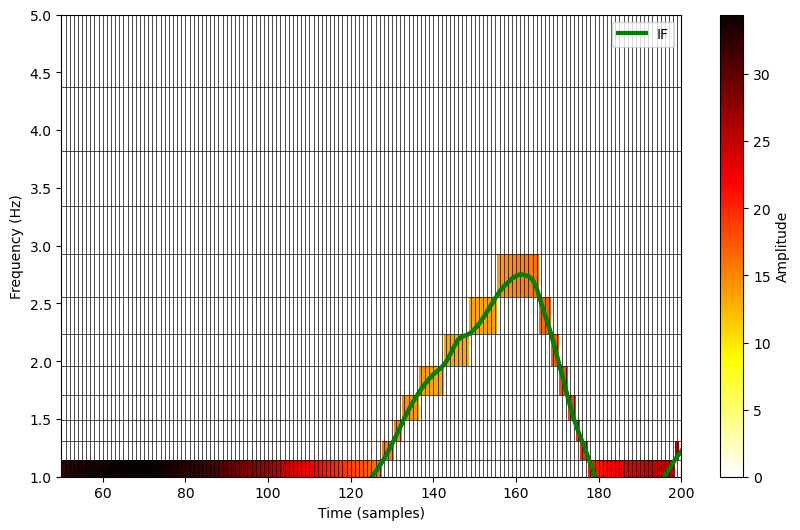

In [72]:
plt.show()

Note that the colour map in the bottom panel carefully tracks the instantaneous amplitude (top-panel in red) of the IMF at the full sample rate of the data. When there is a high amplitude, we can see rapid changes in instantaneous frequency - even within single cycles of the 12Hz oscillation.

The black rectangle in the lower panel shows the part of the signal that we were visualising above.

Sometimes the binning in the Hilbert-Huang Transform can make the signal appear discontinuous. To reduce this effect we can apply a small amount of smoothing to the HHT image. Here we repeat the figure above to plot a smoothed HHT. We use a gaussian image filter from the scipy.ndimage toolbox for the smoothing.

In [73]:
# Carrier frequency histogram definition
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 25, 24*3, 'linear')

hht = emd.spectra.hilberthuang(IF[:, 2], IA[:, 2], freq_edges, mode='amplitude')
time_centres = np.arange(2051)-.5

plt.figure(figsize=(10, 8))
# Add signal and IA
plt.axes([.1, .6, .64, .3])
plt.plot(imf[:, 2], 'k')
plt.plot(IA[:, 2], 'r')
plt.legend(['IMF', 'IF'])
plt.xlim(0, 2050)

# Add IF axis and legend
plt.axes([.1, .1, .8, .45])

# Plot HHT
plt.pcolormesh(time_centres, freq_edges, hht[:, :2050], cmap='hot_r', vmin=0)

# Set colourbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

# Set lims and labels
plt.xlim(0, 2050)
plt.ylim(1, 5)
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')

rect = patches.Rectangle((50, 8), 100, 8, edgecolor='k', facecolor='none')
plt.gca().add_patch(rect)

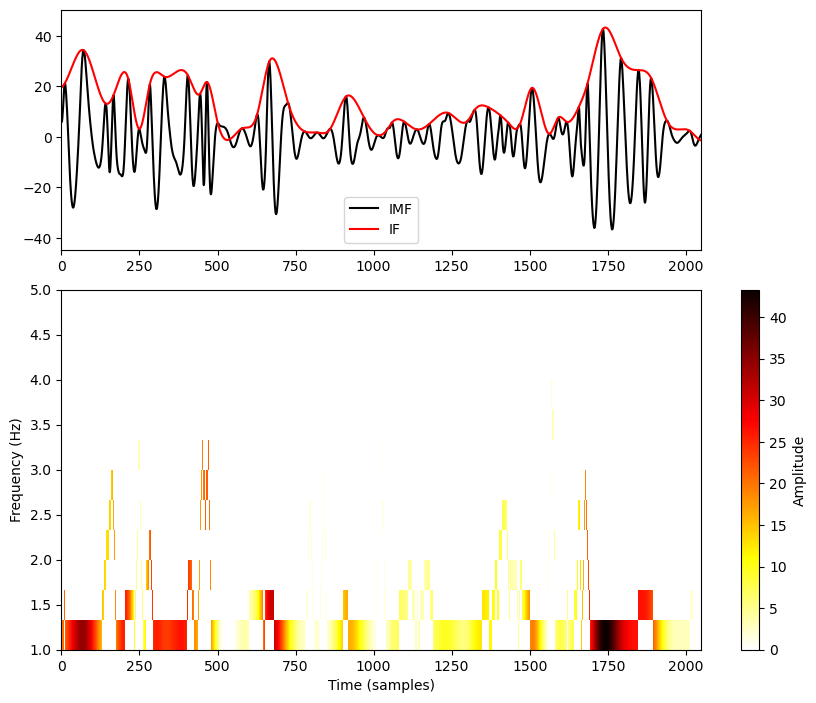

In [74]:
plt.show()

This smoothing step often makes the HHT image easier to read and interpret.

#Making Hilbert-Huang Transform Plots

In [75]:
# Carrier frequency histogram definition
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 25, 24*3, 'linear')

hht = emd.spectra.hilberthuang(IF[:, 2], IA[:, 2], freq_edges, mode='amplitude')
time_centres = np.arange(2051)-.5

# Apply smoothing
hht = ndimage.gaussian_filter(hht, .7)

plt.figure(figsize=(10, 8))
# Add signal and IA
plt.axes([.1, .6, .64, .3])
plt.plot(imf[:, 2], 'k')
plt.plot(IA[:, 2], 'r')
plt.legend(['IMF', 'IF'])
plt.xlim(0, 2050)

# Add IF axis and legend
plt.axes([.1, .1, .8, .45])

# Plot HHT
plt.pcolormesh(time_centres, freq_edges, hht[:, :2050], cmap='hot_r', vmin=0)

# Set colourbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

# Set lims and labels
plt.xlim(0, 2050)
plt.ylim(1, 5)
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')

rect = patches.Rectangle((50, 8), 100, 8, edgecolor='k', facecolor='none')
plt.gca().add_patch(rect)

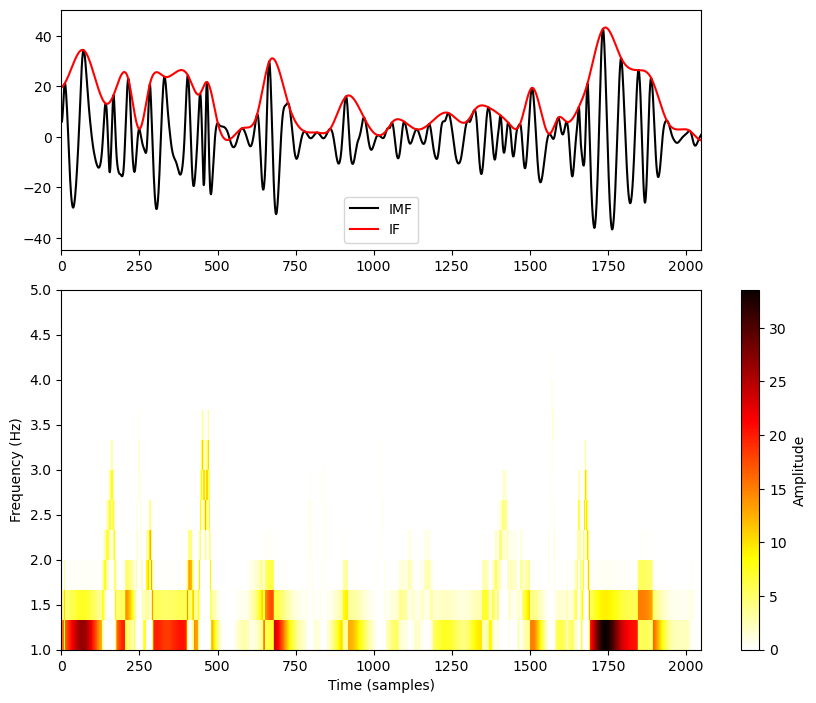

In [76]:
plt.show()

Finally, we include a helper function for plotting Hilbert-Huang transforms - emd.plotting.plot_hilberthuang. This takes a HHT matrix, and corresponding time and frequency vector as inputs and procudes a configurable plot. For example:

In [87]:
emd.plotting.plot_hilberthuang(hht, time_centres, freq_centres[1:10])

<AxesSubplot:title={'center':'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

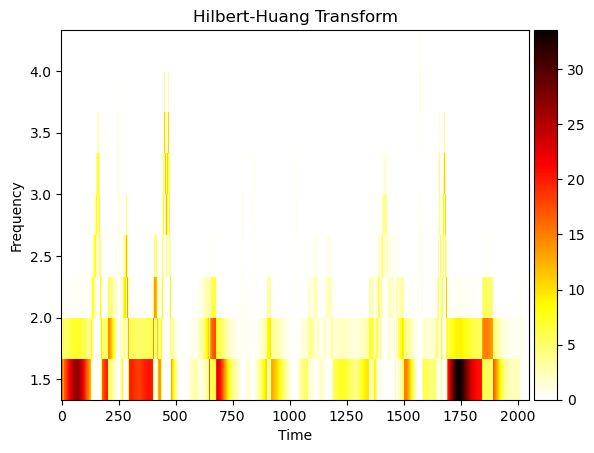

In [88]:
plt.show()

This function is highly configurable - a full list of options can be found in the function docstring. Here we change the colourmap, set the y-axis to a log scale and zoom into a specified time-range.

In [89]:
emd.plotting.plot_hilberthuang(hht, time_centres, freq_centres[1:10],
                               cmap='viridis', time_lims=(750, 2500),  log_y=True)

<AxesSubplot:title={'center':'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

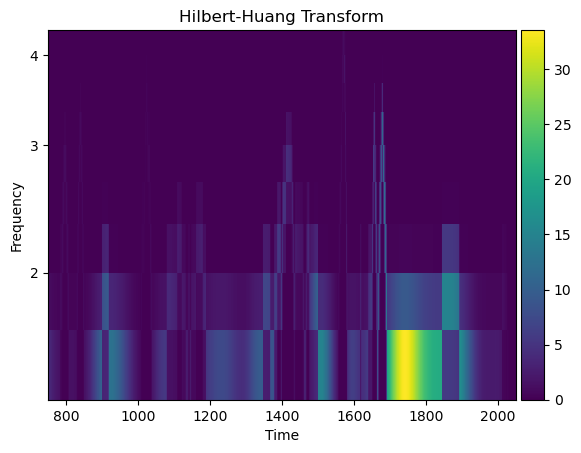

In [90]:
plt.show()